## To build a model able to count fingers as well as distinguish between left and right hand.
Dataset - https://www.kaggle.com/koryakinp/fingers

### I have used **ResNet50** model and trained it with help of Tranfer learning approach using Keras.

In [2]:
import tensorflow.keras as keras
import tensorflow as tf
import os
from PIL import Image
import numpy as np
from numpy import asarray
from numpy import expand_dims
from numpy import load
from numpy import savez_compressed
import matplotlib.pyplot as plt

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

%config Completer.use_jedi = False

#enter your directry path
dataset_dir = './' 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


### I already load all images and saved in "**fingers_train.npz**" file

In [7]:
#load dataset
with load(dataset_dir + 'fingers_train.npz') as data:
  X_train, X_test, y_train, y_test = data['arr_0'],data['arr_1'],data['arr_2'],data['arr_3']

### Mapping of original labels with categorical variables<br>
**Notations**:<br>
3L = 3 fingers of left hand<br>
5R = 5 fingers of right hand

In [8]:
#mapping of original classes with categorical variable
label_dict = {}
for i in range(12):
  if i <=5:
    label_dict[i] = str(i)+'L'
    continue
  label_dict[i] = str(i-6)+'R'
for i in label_dict:
  print(f"{label_dict[i]} -> {i}")

0L -> 0
1L -> 1
2L -> 2
3L -> 3
4L -> 4
5L -> 5
0R -> 6
1R -> 7
2R -> 8
3R -> 9
4R -> 10
5R -> 11


### Exploring Datasets

Train Images:(18000, 128, 128, 3)
Test Images:(3600, 128, 128, 3)
y_train shape:(18000, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(0, 18000 + 1) instead
  """


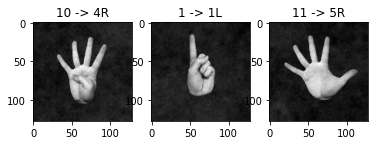

In [9]:

print(f"Train Images:{X_train.shape}")
print(f"Test Images:{X_test.shape}")
print(f"y_train shape:{y_train.shape}")
index = np.random.random_integers(0,18000,3)

fig,axes = plt.subplots(1,3)
for ax,ind in zip(axes,index):
  img = array_to_img(X_train[ind])
  ax.imshow(img)
  ax.set_title(f"{y_train[ind][0]} -> {label_dict[y_train[ind][0]]}")


### Now, We need to apply preprocessing on images for ResNet model.<br>
Preprocess function will do follwing tasks:


1.   The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling
2.   Y vector will be converted into one-hot-encodding format<br>
e.g. -  we have 12 ouput classes then,<br>
[2] -> [0,0,1,0,0,0,0,0,0,0,0,0]



In [10]:
def preprocess_data(x,y):
    x_p = keras.applications.resnet50.preprocess_input(x)
    y_p = keras.utils.to_categorical(y,12)
    return x_p,y_p

In [11]:
#data preprocessing
X_train,y_train, = preprocess_data(X_train,y_train)
X_test,y_test = preprocess_data(X_test,y_test)

### Load Resnet50 Model


*   include_top = By seeting this as **False** will allow feature extraction by removing the last dense layers 
*   weights = Here we will use weights of pretrained **"ImageNet"** model. This will reduce time & computation cost.
*   input_tensor = We need to set shape of Input Image. It is observed that ResNet50 is giving good accuracy on **(224,224)** shaped image.





In [30]:
#make a input tensor
input_tensor = keras.Input(shape=(224,224,3))

#make a ResNet model
resnet_model = keras.applications.ResNet50(include_top = False,weights='imagenet',input_tensor = input_tensor)

resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

#### In order to train our model we does not need to train all weights. We have to train only last layer as per our dataset. So We have to freeze all previous layers' weights. 

In [10]:
#layers of ResNet model
Layers = resnet_model.layers
print(f"Total layers = {len(Layers)}")

#Transfer Learning
#freeze all layers except last block(conv5)
for ind,each in enumerate(Layers):
    if "conv5" not in each.name:
        each.trainable = False

Total layers = 175


### Now we'll append follwing layers to this ResNet50 model in Keras Sequential model


1.   Lambda Layer : to convert Image into given size (224,224)
2.   Flatten() -> BatchNormalization()
3.   Dense(256,"relu") -> Dropout(0.5) -> BatchNormalization()
4.   Dense(128,"relu") -> Dropout(0.5) -> BatchNormalization()
5.   Dense(64,"relu") -> Dropout(0.5) -> BatchNormalization()
6.   Dense(12,"softmax") == output layer






In [11]:
#initialize keras model
model = keras.Sequential()

#ResNet50 gives high accuracy on Image of Shape (224,224)
#resize each image to (224,224)
size = (224,224)

#create Lambda Layer to resize an image
model.add(keras.layers.Lambda(lambda image: tf.image.resize(image,(224,224))))

#add resnet_model (ResNet50)
model.add(resnet_model)

#add flatten layer
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())

#Add 3 Dense layers of sizes [256,128,64]
dense_neaurons = [256,128,64]
for size in dense_neaurons:
    
    #add dense layer
    model.add(keras.layers.Dense(size,activation='relu'))
    
    #add droput to avoid overfitting
    model.add(keras.layers.Dropout(0.5))
    
    #BatchNormaliztion
    model.add(keras.layers.BatchNormalization())

#add softmax layer with 12 output labels
model.add(keras.layers.Dense(12,activation='softmax'))

In [12]:
#Callbacks: In Keras, we can use callbacks in our model to perform certain 
#actions in the training such as weight saving.
check_point = keras.callbacks.ModelCheckpoint(filepath= dataset_dir+'fingers.h5',
                                             monitor='val_acc',
                                             mode='max',
                                             save_best_only=True)



*   Optimization method = RMSprop
*   Learning rate: Now, We are using most of pretrained weights so we have to keep LR very samll



In [13]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training

In [14]:
history = model.fit(X_train,y_train,batch_size=32,epochs=6,verbose=1, validation_data = (X_test,y_test), callbacks=[check_point])
#print(hory)

Epoch 1/6
563/563 [==============================] - 128s 160ms/step - loss: 1.5634 - accuracy: 0.5134 - val_loss: 0.0586 - val_accuracy: 1.0000
Epoch 2/6
563/563 [==============================] - 91s 161ms/step - loss: 0.4324 - accuracy: 0.9206 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 3/6
563/563 [==============================] - 91s 161ms/step - loss: 0.2193 - accuracy: 0.9624 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 4/6
563/563 [==============================] - 91s 161ms/step - loss: 0.1360 - accuracy: 0.9782 - val_loss: 9.6244e-04 - val_accuracy: 1.0000
Epoch 5/6
563/563 [==============================] - 91s 161ms/step - loss: 0.0936 - accuracy: 0.9853 - val_loss: 4.5829e-04 - val_accuracy: 1.0000
Epoch 6/6
563/563 [==============================] - 91s 161ms/step - loss: 0.0764 - accuracy: 0.9860 - val_loss: 2.3454e-04 - val_accuracy: 1.0000


### Ploting Accuracy & Loss

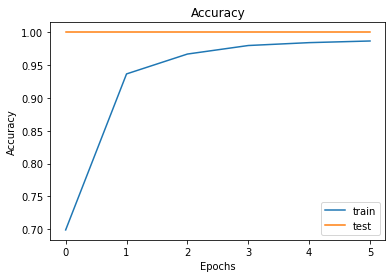

In [31]:
#train accuracy
train_acc = history.history['accuracy']
#test accuracy
test_acc = history.history['val_accuracy']

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
train = plt.plot(train_acc,label='train')
test = plt.plot(test_acc,label='test')
plt.legend()
plt.show()

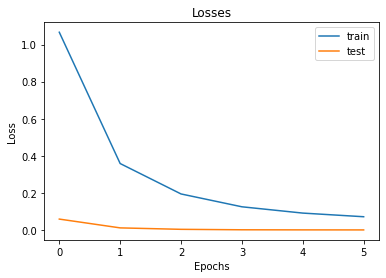

In [32]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
train = plt.plot(train_loss,label='train')
test = plt.plot(test_loss,label='test')
plt.legend()
plt.show()


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

In [ ]:
#save model
#model.save('/content/drive/MyDrive/ResNet Project/fingers.h5')
#load model
model = tf.keras.models.load_model(dataset_dir+'fingers.h5')

### Try Your Own Image & Get Prediction

In [22]:
#try own image

#load images
img1 = load_img(dataset_dir + "0R.jpg")
img2 = load_img(dataset_dir + "3L.jpg")

images = [img1,img2]
img_arr = []

#resize images
for ind,img in enumerate(images):
  images[ind] = img.resize((240,240))

#to set dark background
def blaken_image(img_arr,threshold=80):
  w ,h = img_arr.shape[0], img_arr.shape[1]
  new_img = np.zeros((w,h,3))
  for i in range(w):
    for j in range(h):
      rgb = img_arr[i][j]
      if rgb[0] > threshold:
        new_img[i][j] = rgb
  return new_img

#apply blaken_image() on test images
black_images = []
for img in images:
  black_images.append(blaken_image(img_to_array(img)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


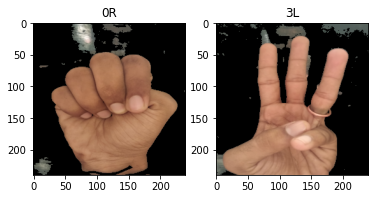

In [23]:
#Make 2 Subplot
fig , axes = plt.subplots(1,2)

#make prediction
pred = model.predict_classes(asarray(black_images))
ind = 0
for ax,img in zip(axes,black_images):
  ax.imshow(array_to_img(img))
  ax.set_title(label_dict[pred[ind]])
  ind+=1
